<a href="https://colab.research.google.com/github/ThalhaAnas/DSGP-31/blob/component3-control/Cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
# After mounting Google Drive, specify the full paths to your files.
# Replace 'your_path_to_file1.csv' and 'your_path_to_file2.csv' with the actual paths.
# Example: '/content/drive/MyDrive/Colab Notebooks/my_data/component3_control_dataset.csv'

files = [
    '/content/drive/MyDrive/DSGP 31/Component 3/component3_control_dataset.csv', # e.g., component3_control_dataset.csv
    '/content/drive/MyDrive/DSGP 31/Component 3/component3_traffic_light_phases.csv'  # e.g., component3_traffic_light_phases.csv
]

# Removed the print statement as paths are now set.

In [32]:
import pandas as pd
import os
from google.colab import data_table # Import the interactive table tool

# The 'files' variable is now correctly defined in the previous cell (6aa0aecf) with full paths.
# We will use that variable here directly.

cleaned_data = None

print("--- STARTING DATA CLEANING ---")

for file_path in files: # Changed file_name to file_path to reflect full path usage
    # Extract just the file name for display purposes if needed
    file_name = os.path.basename(file_path)

    # Check if file exists and is not empty
    if os.path.exists(file_path) and os.path.getsize(file_path) > 0:
        print(f"Processing {file_name}...")
        df = pd.read_csv(file_path)

        # 2. REMOVE DUPLICATES
        initial_count = len(df)
        df = df.drop_duplicates()
        if initial_count - len(df) > 0:
            print(f"   - Removed {initial_count - len(df)} duplicate rows.")

        # 3. SELECT USEFUL COLUMNS (Filtering)
        # We check if this is the control dataset by looking for 'complexity_score'
        if 'complexity_score' in df.columns:
            print("   - Detected Control Dataset. Selecting useful features...")

            # List of columns critical for your models (Linear Regression & K-Means)
            useful_cols = [
                'tl_id',
                'phase_index',
                'duration',
                'num_phases',
                'green_count',
                'red_count',
                'yellow_count',
                'green_ratio',
                'total_cycle',
                'complexity_score'
            ]

            # Keep only the columns that actually exist in the file
            actual_cols_to_keep = [c for c in useful_cols if c in df.columns]
            df = df[actual_cols_to_keep]
            print(f"   - Removed unnecessary columns. Kept: {len(df.columns)} columns.")

        # 4. HANDLE MISSING VALUES
        df = df.dropna()

        # 5. ENSURE NUMERIC TYPES
        # Convert columns to numbers, forcing errors to NaN (then dropped if any)
        numeric_cols = ['duration', 'green_count', 'red_count', 'num_phases', 'total_cycle']
        for col in numeric_cols:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')

        # 6. SAVE CLEANED FILE
        clean_name = f"cleaned_{file_name}"
        df.to_csv(clean_name, index=False)
        print(f"   - Saved cleaned file to: {clean_name}")

        # Store the main dataset to display it later
        if 'complexity_score' in df.columns:
            cleaned_data = df

    else:
        print(f"Skipping {file_name} (File not found or empty).")

print("--- CLEANING COMPLETE ---\n")

# 7. OPTION 1: DISPLAY AS INTERACTIVE TABLE
# This is the "Pro" view for your tutorial
if cleaned_data is not None:
    print("--- DISPLAYING INTERACTIVE DATASET ---")
    print("(You can filter and sort this table interactively)")

    # Enable the interactive formatter
    data_table.enable_dataframe_formatter()

    # Display the dataframe
    display(cleaned_data)
else:
    print("Error: Control dataset was not found or cleaned.")

--- STARTING DATA CLEANING ---
Processing component3_control_dataset.csv...
   - Detected Control Dataset. Selecting useful features...
   - Removed unnecessary columns. Kept: 10 columns.
   - Saved cleaned file to: cleaned_component3_control_dataset.csv
Processing component3_traffic_light_phases.csv...
   - Saved cleaned file to: cleaned_component3_traffic_light_phases.csv
--- CLEANING COMPLETE ---

--- DISPLAYING INTERACTIVE DATASET ---
(You can filter and sort this table interactively)


,tl_id,phase_index,duration,num_phases,green_count,red_count,yellow_count,green_ratio,total_cycle,complexity_score
0,10181862343,0,41,4,4,4,0,0.499938,90,85.44
1,10181862343,1,4,4,1,4,3,0.124984,90,85.44
2,10181862343,2,41,4,5,3,0,0.624922,90,85.44
3,10181862343,3,4,4,1,3,4,0.124984,90,85.44
4,10268955039,0,82,3,1,0,0,0.999001,90,135.12
...,...,...,...,...,...,...,...,...,...,...
261,9485422768,3,4,4,0,5,3,0.000000,90,85.44
262,9788684069,0,41,4,3,5,0,0.374953,90,85.44
263,9788684069,1,4,4,0,5,3,0.000000,90,85.44
264,9788684069,2,41,4,5,3,0,0.624922,90,85.44


✅ Loaded Cleaned Data Successfully

--- MODEL PERFORMANCE RESULTS ---
Mean Squared Error: 177.41
R² Score: 0.6769 (Accuracy)


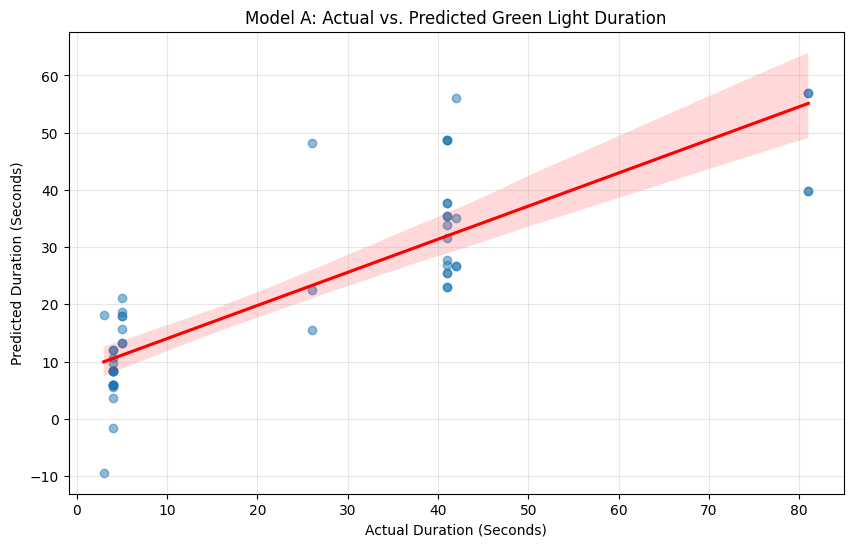


--- SAMPLE PREDICTIONS (First 5) ---
     Actual  Predicted
181      41  35.393060
119       4   8.297567
139      42  26.618312
216      41  25.394991
45       41  37.759512


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import os

# 1. LOAD DATA
# We load the CLEANED file we just created
file_path = 'cleaned_component3_control_dataset.csv'

if os.path.exists(file_path):
    df = pd.read_csv(file_path)
    print("✅ Loaded Cleaned Data Successfully")

    # 2. DEFINE FEATURES (Inputs) & TARGET (Output)
    # Goal: Predict 'duration' based on complexity and traffic counts
    features = ['green_count', 'red_count', 'complexity_score', 'num_phases']
    target = 'duration'

    # Check if all columns exist
    if all(col in df.columns for col in features + [target]):
        X = df[features]
        y = df[target]

        # 3. SPLIT DATA (80% Train, 20% Test)
        # Random state ensures you get the same result every time you show your tutor
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # 4. TRAIN MODEL
        model = LinearRegression()
        model.fit(X_train, y_train)

        # 5. PREDICT & EVALUATE
        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        print("\n--- MODEL PERFORMANCE RESULTS ---")
        print(f"Mean Squared Error: {mse:.2f}")
        print(f"R² Score: {r2:.4f} (Accuracy)")

        # 6. VISUALIZE: Actual vs Predicted
        # This graph proves the model works
        plt.figure(figsize=(10, 6))
        sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
        plt.xlabel('Actual Duration (Seconds)')
        plt.ylabel('Predicted Duration (Seconds)')
        plt.title('Model A: Actual vs. Predicted Green Light Duration')
        plt.grid(True, alpha=0.3)
        plt.show()

        # 7. SHOW SAMPLE PREDICTIONS
        print("\n--- SAMPLE PREDICTIONS (First 5) ---")
        results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
        print(results.head())

    else:
        print("Error: One or more required columns are missing from the dataset.")
else:
    print("Error: Cleaned file not found. Please run the Cleaning Code first.")